In [2]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Core engine
from engine.data_loader import load_fred_series
from engine.geometry.mass_inputs import load_mass_fields, load_calm_mass_fields
from engine.geometry.stress_energy import build_stress_energy
from engine.geometry.curvature import map_curvature
from engine.geometry.gravity import build_gravity

from engine.core.reactor import run_reactor
from engine.calm.refinery import run_calm_refinery
from engine.calm.pnl import calm_pnl
from engine.portfolio import route_capital

# Explainability / reporting
from reports.gravity_reports import build_event_table


In [4]:
from engine.geometry.mass_inputs import load_mass_fields
from engine.geometry.stress_energy import build_stress_energy
from engine.geometry.curvature import map_curvature
from engine.geometry.gravity import build_gravity



In [5]:
funding, collateral, liquidity = load_mass_fields()

T = build_stress_energy(funding, collateral, liquidity)
C = map_curvature(T)
G = build_gravity(C)


In [6]:
G.value_counts()


GRAVITY
0    32
1     4
Name: count, dtype: int64

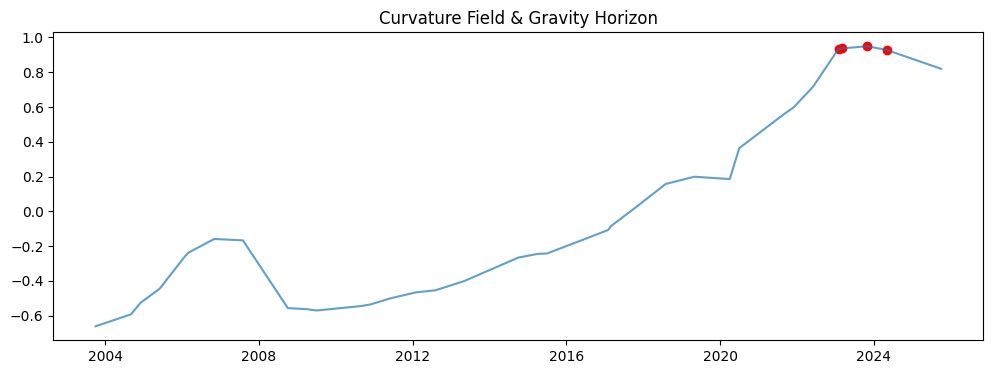

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(C, alpha=0.7)
plt.scatter(G[G==1].index, C[G==1], color="red")
plt.title("Curvature Field & Gravity Horizon")
plt.show()


In [8]:
from engine.core.reactor import run_reactor
from engine.data_loader import load_fred_series

sp = load_fred_series("SP500")["SP500"].pct_change().dropna()
pnl = run_reactor(sp, G)


C:\Users\abhro\AppData\Local\Temp\ipykernel_18264\810414027.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp = load_fred_series("SP500")["SP500"].pct_change().dropna()


In [9]:
equity = (1 + pnl.fillna(0)).cumprod()
equity.tail()


date
2025-12-18    1.000513
2025-12-19    1.000513
2025-12-22    1.000513
2025-12-23    1.000513
2025-12-24    1.000513
Name: REACTOR_PNL, dtype: float64

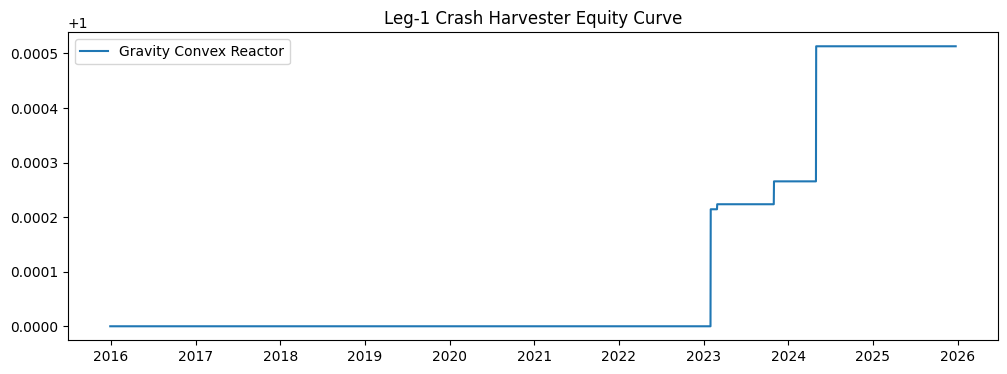

In [10]:
plt.figure(figsize=(12,4))
plt.plot(equity, label="Gravity Convex Reactor")
plt.title("Leg-1 Crash Harvester Equity Curve")
plt.legend()
plt.show()


In [11]:
price = load_fred_series("SP500")["SP500"].dropna()


In [12]:
calm_exposure = run_calm_refinery(G)
calm_leg_pnl = calm_pnl(calm_exposure, price)





In [14]:
from engine.calm.refinery import run_calm_refinery

price = load_fred_series("SP500")["SP500"].dropna()
calm_exposure = run_calm_refinery(G)
calm_leg_pnl = calm_pnl(calm_exposure, price)



In [15]:
from engine.portfolio import route_capital

portfolio_pnl = route_capital(pnl, calm_exposure)


In [16]:
equity_total = (1 + portfolio_pnl.fillna(0)).cumprod()
equity_leg2 = (1 + calm_leg_pnl.fillna(0)).cumprod()



c:\Users\abhro\OneDrive\Desktop\quant-projects\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:54: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [17]:
equity_leg1 = (1 + pnl.fillna(0)).cumprod()
equity_leg2 = (1 + calm_leg_pnl.fillna(0)).cumprod()
equity_total = (1 + portfolio_pnl.fillna(0)).cumprod()


c:\Users\abhro\OneDrive\Desktop\quant-projects\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


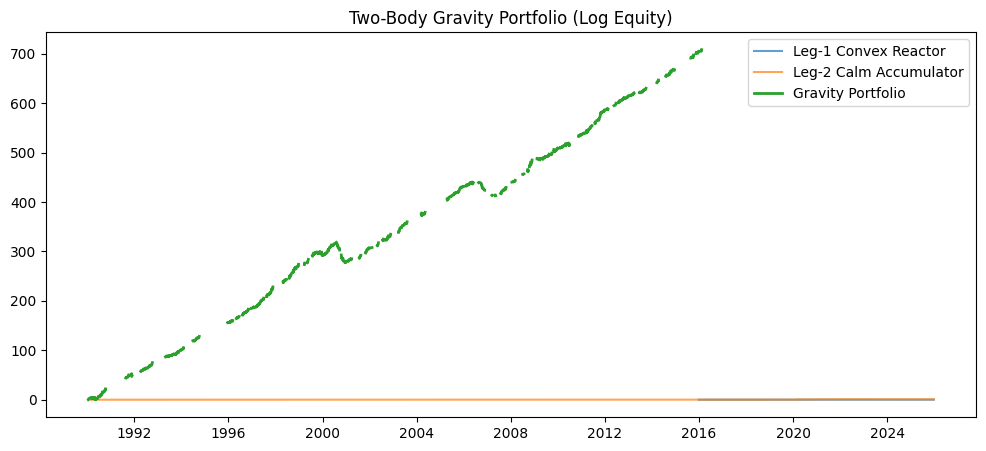

In [18]:
import numpy as np
plt.figure(figsize=(12,5))
plt.plot(np.log(equity_leg1), label="Leg-1 Convex Reactor", alpha=0.7)
plt.plot(np.log(equity_leg2), label="Leg-2 Calm Accumulator", alpha=0.7)
plt.plot(np.log(equity_total), label="Gravity Portfolio", linewidth=2)
plt.legend()
plt.title("Two-Body Gravity Portfolio (Log Equity)")
plt.show()



In [19]:
# Canonical clock = SP500 trading days
clock = sp.index

pnl_m = pnl.reindex(clock).fillna(0)
calm_pnl_m = calm_leg_pnl.reindex(clock).fillna(0)
port_pnl_m = portfolio_pnl.reindex(clock).fillna(0)
Gm = G.reindex(clock).ffill().fillna(0)


In [21]:
def regime_sharpe(pnl, mask):
    x = pnl[mask].replace([np.inf, -np.inf], np.nan).dropna()
    if len(x) < 3:
        return 0
    return np.sqrt(252) * x.mean() / x.std()


In [22]:
leg1_sh = regime_sharpe(pnl_m, Gm == 1)
leg2_sh = regime_sharpe(calm_pnl_m, Gm == 0)

active = (pnl_m != 0) | (calm_pnl_m != 0)
total_active = port_pnl_m[active].replace([np.inf, -np.inf], np.nan).dropna()

total_sh = np.sqrt(252) * total_active.mean() / total_active.std()

print("Leg-1 Regime Sharpe:", leg1_sh)
print("Leg-2 Regime Sharpe:", leg2_sh)
print("Total Energy Sharpe:", total_sh)





Leg-1 Regime Sharpe: 0.9364089091939972
Leg-2 Regime Sharpe: 0.5998895634687923
Total Energy Sharpe: 5.4778805565118525
